In [0]:
# Colab has two versions of TensorFlow installed: a 1.x version and a 2.x version. 
# Colab currently uses TF 1.x by default
# To enable TF2 execute the following code

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


### Importing the necessary Libraries 

In [0]:
# Importing the libraries 
import tensorflow as tf
from keras.utils import np_utils
import numpy as np 
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Creation of some useful functions that would be utilized in our TensorFlow Program 

In [0]:
# -------------------------------------------CODE TO PREPARE THE DATASET---------------------------------------------------- 

def prepare_dataset(fashion_mnist):
  # load the training and test data    
  (tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()
  # reshape the feature data
  tr_x = tr_x.reshape(tr_x.shape[0], 784)
  te_x = te_x.reshape(te_x.shape[0], 784)
  # noramlise feature data
  tr_x = tr_x / 255.0
  te_x = te_x / 255.0
  # one hot encode the training labels and get the transpose
  tr_y = np_utils.to_categorical(tr_y,10)
  tr_y = tr_y.T
  # one hot encode the test labels and get the transpose
  te_y = np_utils.to_categorical(te_y,10)
  te_y = te_y.T
  return tr_x, tr_y, te_x, te_y

# -----------------------------------CODE TO CALCULATE THE PROBABILITY OF EACH CLASS GIVEN THE TRAINING INSTANCE--------------------------------------

def forward_pass(X_train, weight_matrix, bias_matrix):
  """
  Return the predicted 10 class probabilities matrix for each of the training instances given the training feature matrix and weights matrix 
  """
  # Calculate the pre-activation outputs for each of the 10 neurons in the softmax layer for each of the training instance 
  # Will get 10 outputs for a single training instance in the form of (10*60000) matrix 
  # The size of the weight matrix is (10*784)
  # The size of the training feature matrix is (784*60000)
  # The size of the bias matrix is (10*1)
  preActivation_output_matrix=  tf.matmul(weight_matrix, X_train) + bias_matrix
  # Calculate a new matrix where each element is e to the power of pre-activation outputs 
  exponential_matrix= tf.math.exp(preActivation_output_matrix)
  # Calculation of the final probabilities of each of the 10 classes for each instance in the training set 
  # Column wise sum calculation 
  column_sum= tf.reduce_sum(exponential_matrix, 0)
  # Divide each element by the column sum so that each column is the probability of each class of a single instance 
  probability_matrix= exponential_matrix/column_sum 
  
  return probability_matrix

# -------------------------------- CODE TO CALCULATE THE LOSS FOR THE CURRENT SET OF TUNABLE PARAMETERS / WEIGHTS-------------------------------------

def cross_entropy(y_train, y_pred_matrix):
  """
  Return the loss value given the predicted probabilities matrix and the actual probabilities matrix
  """
  # Compute the log of each element of the prediction matrix 
  log_matrix= tf.math.log(y_pred_matrix)
  # Multiply each element of the actual labels matrix with the log matrix 
  product_matrix= y_train *log_matrix
  # Take the negation of each element in the product matrix 
  negated_product_matrix= -1*(product_matrix)
  # Compute the cross entropy loss for each of the training instances 
  # This will contain individual loss for the all training instances 
  # This operation will perform the column wise sum 
  single_loss_matrix= tf.reduce_sum(negated_product_matrix, 0)
  # Compute the mean cross entropy loss 
  mean_loss= tf.reduce_mean(single_loss_matrix)

  return mean_loss

# ----------------------------------------- CALCULATION OF THE TRAINING AND TEST SET ACCURACY------------------------------------------------------

def return_labels(matrix):
  """
  Return the corrosponding class label for each vector of probability instance 
  """ 
  class_labels= tf.argmax(matrix) 
  
  return class_labels

def calculate_accuracy(feature_data, label_data, weight_matrix, bias_matrix):
  """ 
  Return the accuracy value (applicable for both train and the test set) for the given set of weights and the biases 
  """
  # Calculate the matrix of predicted probabilities through calling of forward pass 
  predicted_matrix= forward_pass(feature_data, weight_matrix, bias_matrix)
  # Get the class labels of the actual labels 
  actual_labels= return_labels(label_data)
  # Get the class labels of the predicted probabilities 
  predicted_labels= return_labels(predicted_matrix)
  # Get the correct prediction in the form of boolean array where 1 is correct prediction and 0 is the wrong prediction 
  correct_predictions= tf.cast(tf.equal(predicted_labels, actual_labels), tf.float32)
  # Calculate the accuracy 
  accuracy= tf.reduce_mean(correct_predictions)

  return accuracy 


### Beginning of our TensorFlow Program 

In [0]:
# Loading the fashion MNIST data-set 
fashion_mnist = tf.keras.datasets.fashion_mnist

# Prepare the dataset 
train_features, train_labels, test_features, test_labels= prepare_dataset(fashion_mnist)

# Get the transpose of feature data 
train_features= train_features.T 
test_features= test_features.T

# Print the shape of our 4 data structures 
print( "Shape of training features ", train_features.shape)
print ("Shape of training labels ", train_labels.shape)
print()
print( "Shape of test features ", test_features.shape)
print ("Shape of test labels ", test_labels.shape)
print()
print("The training process of our Softmax Neural Network begins.....")
print()

X_train= tf.cast(train_features, tf.float32)
y_train= tf.cast(train_labels, tf.float32)
X_test= tf.cast(test_features, tf.float32)
y_test= tf.cast(test_labels, tf.float32)

# Set the Number of features
num_features=  X_train.shape[0]
# We now specify the size of output layer 
output_neurons= 10 

# Initialize the weight_matrix and bias_matrix 
# Each row of this matrix represents the 784 weights of a single neuron in the softmax layer 
weight_matrix= tf.Variable(tf.random.normal([output_neurons, num_features], mean=0.0, stddev=0.05))
# It is a column vector where each row/element represents the bias value for a single neuron in the softmax layer 
bias_matrix= tf.Variable(tf.random.normal([output_neurons, 1], mean=0.0, stddev=0.05))

# Set the learning rate and the number of iterations 
learning_rate= 0.01 
num_iterations= 6000

# Adam optimizer to update the weights of the neural network 
adam_optimizer= tf.keras.optimizers.Adam()

# Create the list to store the training accuracy and loss with each iteration 
training_loss= []
training_acc= []
# Create the list to store the test accuracy and loss with each iteration 
test_loss= []
test_acc= []

# Run the gradient descent to num_iterations number of times 
for iteration in range(num_iterations):

  # Create an instance of GradientTape to monitor the forward pass and loss calculations
  with tf.GradientTape() as tape:
    # Calculate the predicted probability matrix for the current weights and the biases for the training set
    y_pred_matrix= forward_pass(X_train, weight_matrix, bias_matrix)
    # Calculate the predicted probability matrix for the current weights and the biases for the test set
    y_pred_test= forward_pass(X_test, weight_matrix, bias_matrix)
    # Calculate the current training loss with the current predictions and the actual labels of the training set 
    current_loss_training= cross_entropy(y_train, y_pred_matrix)
    # Calculate the current test loss with the current prediction and the actual labels of the test set 
    current_loss_test= cross_entropy(y_test, y_pred_test)
  
  # Calculate the gradients (partial derivates) of the loss with respect to each of the tunable weights 
  gradients= tape.gradient(current_loss_training, [weight_matrix, bias_matrix])

  # Calculate the training accuracy with each iteration 
  training_accuracy= calculate_accuracy(X_train, y_train, weight_matrix, bias_matrix)

  # Calculate the test accuracy with each each iteration 
  test_accuracy= calculate_accuracy(X_test, y_test, weight_matrix, bias_matrix)

  # Print out the current iteration, current loss and current training accuracy 
  print("Iteration ",iteration, ": Loss = ",current_loss_training.numpy()," Acc: ", training_accuracy.numpy(),   'Val_loss = ',current_loss_test.numpy(),   'Val_acc = ', test_accuracy.numpy())

  # Apply the Adam optimizer to update the weights and biases 
  adam_optimizer.apply_gradients(zip(gradients, [weight_matrix, bias_matrix]))

  # Append the 4 values (train loss, train acc, test loss, test acc) with the each current iteration for the plotting 
  training_loss.append(current_loss_training.numpy())
  training_acc.append(training_accuracy.numpy())
  test_loss.append(current_loss_test.numpy())
  test_acc.append(test_accuracy.numpy())

# Calculate the test accuracy with the final updated weights and the biases through adam optimizer after running for certain number of iterations 
final_test_accuracy= calculate_accuracy(X_test, y_test, weight_matrix, bias_matrix)

# Print the test accuracy 
print()
print("The final test accuracy of the Fashion MNIST dataset is {}".format(final_test_accuracy))

Streaming output truncated to the last 5000 lines.
Iteration  1003 : Loss =  0.4264263  Acc:  0.85758334 Val_loss =  0.46910346 Val_acc =  0.8377
Iteration  1004 : Loss =  0.42636007  Acc:  0.8576 Val_loss =  0.46905473 Val_acc =  0.8379
Iteration  1005 : Loss =  0.4262939  Acc:  0.85763335 Val_loss =  0.46900615 Val_acc =  0.8379
Iteration  1006 : Loss =  0.42622787  Acc:  0.85765 Val_loss =  0.4689576 Val_acc =  0.8379
Iteration  1007 : Loss =  0.42616192  Acc:  0.8576667 Val_loss =  0.46890917 Val_acc =  0.8379
Iteration  1008 : Loss =  0.42609602  Acc:  0.85768336 Val_loss =  0.46886083 Val_acc =  0.8379
Iteration  1009 : Loss =  0.42603028  Acc:  0.85768336 Val_loss =  0.46881258 Val_acc =  0.8379
Iteration  1010 : Loss =  0.42596465  Acc:  0.8577167 Val_loss =  0.46876445 Val_acc =  0.8379
Iteration  1011 : Loss =  0.42589903  Acc:  0.8577 Val_loss =  0.46871635 Val_acc =  0.8379
Iteration  1012 : Loss =  0.42583352  Acc:  0.8577333 Val_loss =  0.46866837 Val_acc =  0.8379
Iterat

### Plot of Training accuracy, Training loss, Test Accuracy, Test Loss against the number of Iterations 

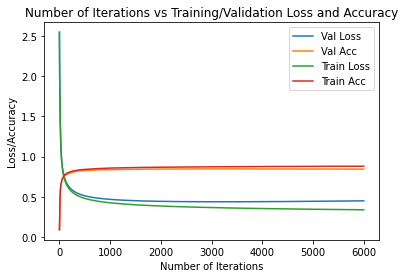


The final test accuracy of the Fashion MNIST dataset is 0.8446999788284302


In [0]:
plt.plot(test_loss, label="Val Loss")
plt.plot(test_acc, label="Val Acc")
plt.plot(training_loss, label="Train Loss")
plt.plot(training_acc, label="Train Acc")
plt.title("Number of Iterations vs Training/Validation Loss and Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
# Print the test accuracy 
print()
print("The final test accuracy of the Fashion MNIST dataset is {}".format(final_test_accuracy))

### Plot of number of iterations and the test set accuracy 

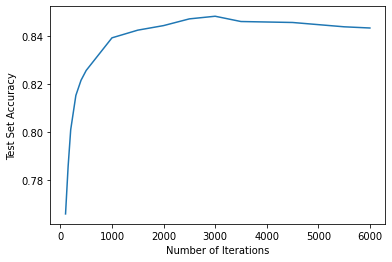

In [0]:
iterations= [100, 150, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
acc_test= [0.765999972820282, 0.7857999801635742, 0.8011000156402588, 0.8154000043869019, 0.8216999769210815, 0.8258000016212463, 0.8393999934196472, 0.8425999879837036, 0.8445000052452087, 0.8472999930381775, 0.8483999967575073, 0.8461999893188477, 0.8460000157356262, 0.84579998254776, 0.8449000120162964, 0.843999981880188, 0.843500018119812]
plt.plot(iterations, acc_test)
plt.xlabel("Number of Iterations")
plt.ylabel("Test Set Accuracy")
plt.show()